[Reference](https://rbdundas.medium.com/calculate-relative-strength-index-rsi-and-chart-with-candles-using-python-pandas-and-matplotlib-f58d926249ac)

In [1]:
!pip install python-dotenv
!pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 625 kB/s 
     |████████████████████████████████| 6.4 MB 7.2 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


<Figure size 1152x576 with 0 Axes>

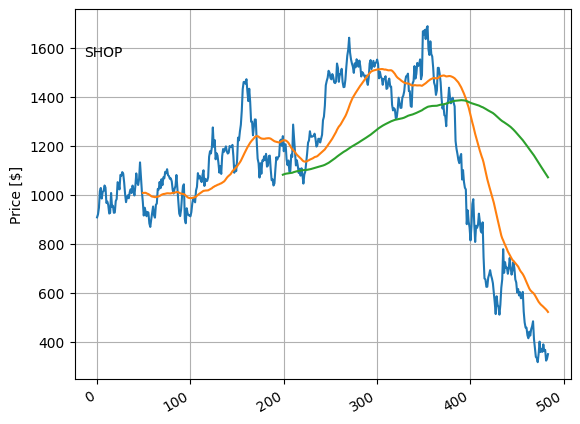

In [2]:
import json
import os
from pathlib import Path
from datetime import datetime, timedelta
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import requests
from yahooquery import Ticker


tda_url = 'https://api.tdameritrade.com/v1/marketdata/{ticker}/pricehistory'

load_dotenv()


def get_database_connection():
    conn = psycopg2.connect(
        dbname=os.environ['dbname'],
        user=os.environ['dbusername'],
        password=os.environ['dbpassword']
    )
    return conn


def get_price_history(symbol):
    ticker = Ticker(symbol)
    df = ticker.history()
    df = df.reset_index()
    return df


def get_up_or_down(df):
    for i in range(len(df)):
        if df.iloc[i]['close'] >= df.iloc[i-1]['close']:
            df.at[i, 'gain'] = df.iloc[i]['close'] - df.iloc[i-1]['close']
            df.at[i, 'loss'] = 0
        elif df.iloc[i]['close'] < df.iloc[i-1]['close']:
            df.at[i, 'loss'] = df.iloc[i-1]['close'] - df.iloc[i]['close']
            df.at[i, 'gain'] = 0
        else:
            df.at[i, 'gain'] = 0
            df.at[i, 'loss'] = 0
    return df


def get_average_gains(df, period):
    for i in range(len(df)):
        n, up, down = 0, 0, 0
        if i == period:
            while n < period:
                if df.iloc[i-n]['gain'] > 0:
                    up += df.iloc[i-n]['gain']
                elif df.iloc[i-n]['loss'] > 0:
                    down += df.iloc[i-n]['loss']
                else:
                    up += 0
                    down += 0
                n += 1
            df.at[i, 'ag'] = up/period
            df.at[i, 'al'] = down/period
        elif i > period:
            df.at[i, 'ag'] = (df.iloc[i-1]['ag'] * (period - 1) + df.iloc[i]['gain'])/period
            df.at[i, 'al'] = (df.iloc[i-1]['al'] * (period - 1) + df.iloc[i]['loss'])/period
            df['ag'] = df['ag'].fillna(0)
            df['al'] = df['al'].fillna(0)
    return df


def get_relative_strength(df, period):
    for i in range(len(df)):
        if i >= period:
            df.at[i, 'rs'] = df.iloc[i]['ag']/df.iloc[i]['al']
            df.at[i, 'rsi'] = (100-(100/(1+df.iloc[i]['rs'])))
    return df


def get_relative_strength_index(df):
    df = get_up_or_down(df)
    df = get_average_gains(df, 14)
    df = get_relative_strength(df, 14)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 1000)
    return df


def get_stochastic_oscillator(df, period=14):
    for i in range(len(df)):
        low = df.iloc[i]['close']
        high = df.iloc[i]['close']
        if i >= period:
            n = 0
            while n < period:
                if df.iloc[i-n]['close'] >= high:
                    high = df.iloc[i-n]['close']
                elif df.iloc[i-n]['close'] < low:
                    low = df.iloc[i-n]['close']
                n += 1
            df.at[i, 'best_low'] = low
            df.at[i, 'best_high'] = high
            df.at[i, 'fast_k'] = 100*((df.iloc[i]['close']-df.iloc[i]['best_low'])/(df.iloc[i]['best_high']-df.iloc[i]['best_low']))

    df['fast_d'] = df['fast_k'].rolling(3).mean().round(2)
    df['slow_k'] = df['fast_d']
    df['slow_d'] = df['slow_k'].rolling(3).mean().round(2)

    return df


def get_moving_averages(symbol):
    ticker = Ticker(symbol)
    end_date = datetime.today() - timedelta(days=700)
    df = ticker.history(
        period='year', interval='1d', start=end_date, end=datetime.today())
    df = df.reset_index()
    df['ma50'] = df['close'].rolling(50).mean()
    df['ma200'] = df['close'].rolling(200).mean()
    return df


def chart_price_history(symbol):
    df = get_moving_averages(symbol)

    plt.figure(figsize=[16, 8])
    plt.style.use('default')
    fig, ax = plt.subplots()

    plt.plot(df['close'], label='data')
    plt.plot(df['ma50'], label='data')
    plt.plot(df['ma200'], label='data')

    ax.grid(True)
    ax.set_ylabel(r'Price [\$]')
    ax.set_title(symbol, loc='left', y=0.85, x=0.02, fontsize='medium')
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    plt.show()


def chart_stochastic_oscillator(ticker, df):
    plt.figure(figsize=[16, 8])
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(5, 1))

    plt.plot(df['date'], df['fast_k'], color='orange', linewidth=.75)
    plt.plot(df['date'], df['fast_d'], color='grey', linewidth=.75)
    plt.plot(df['date'], df['slow_d'], color='green', linewidth=.75)

    ax.grid(True)
    ax.set_ylabel(r'Price [\$]')
    ax.set_title(ticker, loc='left', y=0.85, x=0.02, fontsize='medium')
    ax.set_ylim(0, 100)
    ax.axhline(y=80, color='b', linestyle='-')
    ax.axhline(y=20, color='r', linestyle='-')
    plt.show()


def chart_stochastic_oscillator_and_price(ticker, df):

    df['ma50'] = df['close'].rolling(50).mean()
    df['ma200'] = df['close'].rolling(200).mean()

    plt.figure(figsize=[16, 8])
    plt.style.use('default')
    fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(ticker)
    plt.subplots_adjust(hspace=0.02)
    ax[0].grid(True)
    ax[0].axes.get_xaxis().set_visible(False)  # Remove X labels
    ax[0].set_ylabel(r'Price [\$]')
    ax[0].plot(df['close'], color='black', linewidth=1)

    ax[1].plot(df['Date'], df['fast_k'], color='orange', linewidth=1)
    ax[1].plot(df['Date'], df['fast_d'], color='grey', linewidth=1)
    ax[1].plot(df['Date'], df['slow_d'], color='green', linewidth=1)
    ax[1].grid(True)
    ax[1].set_ylabel(r'S.O.')
    ax[1].set_ylim(0, 100)
    ax[1].axhline(y=80, color='b', linestyle='-')
    ax[1].axhline(y=20, color='r', linestyle='-')
    plt.xticks(rotation=30, ha='right')
    plt.show()


def chart_candlesticks(ticker, df):

    width = .5
    width2 = .05

    up = df[df.close >= df.open]
    down = df[df.close < df.open]

    col1 = 'green'
    col2 = 'red'

    plt.figure()
    fig, ax = plt.subplots()
    ax.set_title(ticker)
    fig.subplots_adjust(bottom=0.2)

    plt.grid(True)
    plt.bar(up.index, up.close - up.open, width, bottom=up.open, color=col1)
    plt.bar(up.index, up.high - up.close, width2, bottom=up.close, color=col1)
    plt.bar(up.index, up.low - up.open, width2, bottom=up.open, color=col1)

    plt.bar(down.index, down.close - down.open, width, bottom=down.open, color=col2)
    plt.bar(down.index, down.high - down.open, width2, bottom=down.open, color=col2)
    plt.bar(down.index, down.low - down.close, width2, bottom=down.close, color=col2)
    plt.xticks(rotation=45, ha='right')
    plt.show()


def chart_volume(ticker, df):
    plt.figure()
    fig, ax = plt.subplots()
    ax.set_title(ticker)
    fig.subplots_adjust(bottom=0.2)
    plt.plot(df['volume'], label='data')
    ax.set_ylabel(r'Volume')
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    plt.show()


def chart_rsi(ticker, df):
    plt.figure()
    fig, ax = plt.subplots()
    ax.set_title(ticker)
    fig.subplots_adjust(bottom=0.2)
    ax.plot(df['Date'], df['rsi'])
    ax.set_ylim(0, 100)
    ax.axhline(y=70, color='r', linestyle='-')
    ax.axhline(y=30, color='r', linestyle='-')
    ax.grid(True)
    ax.set_ylabel(r'RSI')
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    plt.show()


def chart_volume_and_averages(ticker, df):
    # Create a new column in dataframe and populate with bar color
    i = 0
    while i < len(df):
        if df.iloc[i]['close'] >= df.iloc[i-1]['close']:
            df.at[i, 'color'] = "green"
        elif df.iloc[i]['close'] < df.iloc[i-1]['close']:
            df.at[i, 'color'] = "red"
        else:
            df.at[i, 'color'] = "blue"
        i += 1

    # Set up the chart
    plt.figure(figsize=[16, 8])
    plt.style.use('default')
    fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(ticker)

    # Draw the price history
    ax[0].plot(df['Date'], df['close'])
    ax[0].axes.get_xaxis().set_visible(False)  # Remove X labels
    ax[0].grid(True)

    # Draw the volume
    ax[1].bar(df['Date'], df['volume'], color=df['color'])
    ax[1].grid(True)

    # Tweak chart to display better
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(bottom=0.2)
    plt.show()


def chart_rsi_with_candles(ticker, df):
    plt.figure()
    fig, ax = plt.subplots(2, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(ticker)

    width = .5
    width2 = .05
    col1 = 'green'
    col2 = 'red'
    up = df[df.close >= df.open]
    down = df[df.close < df.open]
    fig.subplots_adjust(bottom=0.2)

    ax[0].grid(True)
    ax[0].set_ylabel(r'PRICE')
    ax[0].axes.get_xaxis().set_visible(False)  # Remove X labels
    ax[0].bar(up.index, up.close - up.open, width, bottom=up.open, color=col1)
    ax[0].bar(up.index, up.high - up.close, width2, bottom=up.close, color=col1)
    ax[0].bar(up.index, up.low - up.open, width2, bottom=up.open, color=col1)
    ax[0].bar(down.index, down.close - down.open, width, bottom=down.open, color=col2)
    ax[0].bar(down.index, down.high - down.open, width2, bottom=down.open, color=col2)
    ax[0].bar(down.index, down.low - down.close, width2, bottom=down.close, color=col2)

    ax[1].plot(df['date'], df['rsi'])
    ax[1].set_ylim(0, 100)
    ax[1].axhline(y=70, color='r', linestyle='-')
    ax[1].axhline(y=30, color='r', linestyle='-')
    ax[1].grid(True)
    ax[1].set_ylabel(r'RSI')
    for label in ax[1].get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')
    plt.show()


def main():
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.width', 1000)

    symbol = 'SHOP'
    chart_price_history(symbol)


if __name__ == "__main__":
    main()